# CNV Processing

In [1]:
import cPickle
import datetime
import glob
import os
import random
import re
import subprocess
import urllib2

import cdpybio as cpb
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline

dy_name = 'cnv_processing'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'unrelateds.tsv')
unr_rna_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0)

rna_meta = rna_meta.merge(subject_meta, left_on='subject_id', right_index=True)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
gene_info['ensembl_id'] = [x.split('.')[0] for x in gene_info.index]

genes = pbt.BedTool(cpy.gencode_gene_bed)

exp = pd.read_table(os.path.join(ciepy.root, 'output', 'eqtl_input', 
                                 'tpm_log_filtered_phe_std_norm_peer_resid.tsv'), index_col=0)

In [3]:
fn = os.path.join(os.path.split(cpy.roadmap_15_state_annotation)[0], 'EIDlegend.txt')
roadmap_ids = pd.read_table(fn, squeeze=True, index_col=0, header=None)

In [4]:
fn = '/projects/CARDIPS/pipeline/WGS/BF_GS_Discovery/eval/CopyNumberClass.report.dat'
report = pd.read_table(fn, index_col=0)

## Speedseq CNVs

In [5]:
def read_merged_lumpy_vcf(fn):
    """Read and parse a merged VCF of lumpy results."""
    df = pd.read_table(fn, skiprows=641, low_memory=False)
    df.columns = [x.replace('#', '') for x in df.columns]
    df = df[df.ALT.apply(lambda x: x in ['<DEL>', '<DUP>'])]
    gcols = df.columns[8:]
    genotypes = df[gcols]
    genotypes = genotypes.apply(lambda x: [y.split(':')[0] for y in x], axis=1)
    df = df.drop(gcols, axis=1)
    cols = [x.split('=')[0] for x in df.INFO[0].split(';')]
    imprecise = []
    rows = []
    for i in df.index:
        vals = list(df.ix[i, 'INFO'].split(';'))
        if 'IMPRECISE' in vals:
            imprecise.append(True)
            vals.remove('IMPRECISE')
        else:
            imprecise.append(False)
        rows.append(dict([x.split('=') for x in vals]))
    df['imprecise'] = imprecise
    tdf = pd.DataFrame(rows, index=df.index)
    df = df.join(tdf)
    df = df.drop('INFO', axis=1)
    df.CHROM = 'chr' + df.CHROM.astype(str)
    # cols = df.FORMAT[0].split(':')
    # ds = df.apply(lambda x: pd.Series(dict(zip(x['FORMAT'].split(':'), x[df.columns[8]].split(':')))), axis=1)
    # ds = ds.drop(set(df.columns) & set(ds.columns), axis=1)
    # df = df.join(ds)
    # df = df.drop(['FORMAT', df.columns[8]], axis=1)
    df.ALT = df.ALT.apply(lambda x: x[1:4])
    df = df[df.END.isnull() == False]
    for c in ['POS', 'END', 'PE', 'SR', 'SU', 'SVLEN']:
        df[c] = df[c].astype(int)
    return df, genotypes

In [261]:
fn = '/frazer01/home/djakubosky/sandbox/svtools/Lumpy_274_Merged.vcf'
lumpy_info, lumpy_genotypes = read_merged_lumpy_vcf(fn)
lumpy_info['name'] = (lumpy_info.ALT + '_' + lumpy_info.CHROM.apply(lambda x: x[3:]) + 
                      '_' + lumpy_info.POS.astype(str) + '_' + lumpy_info.END.astype(str))
# Some lumpy SVs show up multiple times in the VCF (not sure why) so I'll just keep one.
lumpy_info = lumpy_info.drop_duplicates(subset=['name'])
lumpy_genotypes = lumpy_genotypes.ix[lumpy_info.index]
lumpy_info.index = lumpy_info.name
lumpy_genotypes.index = lumpy_info.name

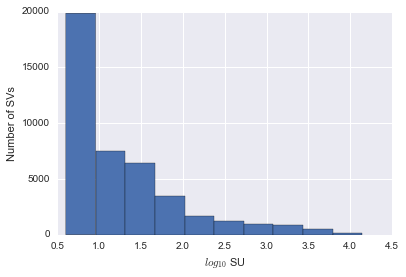

In [267]:
np.log10(lumpy_info.SU).hist()
plt.ylabel('Number of SVs')
plt.xlabel('$log_{10}$ SU');

## Genome Strip CNVs

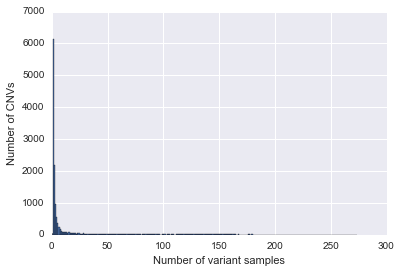

In [8]:
report.NVARIANT.hist(bins=range(275))
plt.ylabel('Number of CNVs')
plt.xlabel('Number of variant samples');

In [9]:
out = os.path.join(private_outdir, 'gs_cnv_genotypes.tsv')
if not os.path.exists(out):
    fn = '/projects/CARDIPS/pipeline/WGS/BF_GS_Discovery/gs_cnv.genotypes.vcf'
    f = open(fn)
    line = f.readline()
    while line[0:2] == '##':
        line = f.readline()
    header = line[1:].strip().split('\t')

    ind = []
    copy_numbers = []
    line = f.readline().strip()
    while line != '':
        t = line.split('\t')
        ind.append(t[2])
        copy_numbers.append([int(x.split(':')[1]) for x in t[9:]])
        line = f.readline().strip()
    cns = pd.DataFrame(copy_numbers, index=ind, columns=header[9:])
    cns.to_csv(out, sep='\t')
else:
    cns = pd.read_table(out, index_col=0)

In [10]:
cnv_info = pd.DataFrame([x.split('_')[1:] for x in cns.index], 
                        index=cns.index, columns=['chrom', 'start', 'end'])
cnv_info['chrom'] = 'chr' + cnv_info.chrom
cnv_info['start'] = cnv_info.start.astype(int)
cnv_info['end'] = cnv_info.end.astype(int)
cnv_info['length'] = cnv_info.end - cnv_info.start
cnv_info['name'] = cnv_info.index

In [11]:
s = '\n'.join(cnv_info.chrom + '\t' + cnv_info.start.astype(str) + 
              '\t' + cnv_info.end.astype(str) + '\t' + cnv_info.name) + '\n'
cnv_bt = pbt.BedTool(s, from_string=True)
cnv_bt = cnv_bt.sort()
cnv_bt.saveas(os.path.join(outdir, 'cnvs.bed'), trackline="track type=bed name='CNVs'")
if not os.path.exists('/home/cdeboever/public_html/cnvs.bed'):
    os.symlink(os.path.join(outdir, 'cnvs.bed'), '/home/cdeboever/public_html/cnvs.bed')

In [12]:
res = cnv_bt.intersect(genes, sorted=True, wo=True)
df = res.to_dataframe()
gb = df.groupby('name')
d = gb.groups
for k in d.keys():
    d[k] = list(df.ix[d[k], 'thickEnd'].values)
se = pd.Series(d)
cnv_info['gene_overlaps'] = np.nan
cnv_info.ix[se.index, 'gene_overlaps'] = se.apply(lambda x: ','.join(x))
tss_bt = pbt.BedTool('/publicdata/gencode_v19_20151104/tss_merged.bed')
res = cnv_bt.closest(tss_bt, D='b')
df = res.to_dataframe()
cnv_info.ix[df.name, 'nearest_tss_dist'] = df.thickEnd.values
cnv_info = cnv_info.join(report)
mode = cns.mode(axis=1)[0]
cnv_info['cn_mode'] = mode
nvariant = [sum(cns.ix[i] != cnv_info.ix[i, 'cn_mode']) for i in cnv_info.index]
cnv_info['diff_from_mode'] = nvariant
cnv_info['percent_diff_from_mode'] = cnv_info.diff_from_mode / cns.shape[1]
t = cns[unr_rna_meta.wgs_id]
nvariant = [sum(t.ix[i] != cnv_info.ix[i, 'cn_mode']) for i in cnv_info.index]
cnv_info['unrelated_diff_from_mode'] = nvariant
cnv_info['unrelated_percent_diff_from_mode'] = cnv_info.unrelated_diff_from_mode / unr_rna_meta.shape[0]
rna_meta_eqtl = rna_meta[rna_meta.in_eqtl]
vc = rna_meta_eqtl.family_id.value_counts()
vc = vc[vc > 4]
for x in vc.index:
    t = cns[rna_meta_eqtl.ix[rna_meta_eqtl.family_id == x, 'wgs_id']]
    pvariant = [sum(t.ix[i] != cnv_info.ix[i, 'cn_mode']) for i in cnv_info.index]
    cnv_info['{}_{}_diff_from_mode'.format(x, vc[x])] = np.array(pvariant)
    cnv_info['{}_{}_percent_diff_from_mode'.format(x, vc[x])] = np.array(pvariant) / float(vc[x])
family_cols = ['{}_{}_percent_diff_from_mode'.format(x, vc[x]) for x in vc.index]
cnv_info.to_csv(os.path.join(outdir, 'cnv_info.tsv'), sep='\t')

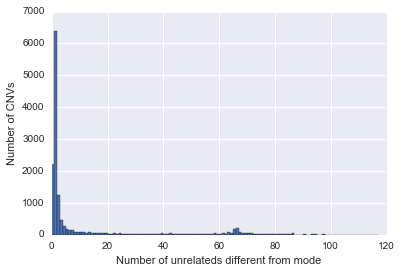

In [13]:
cnv_info.unrelated_diff_from_mode.hist(bins=range(118))
plt.xlabel('Number of unrelateds different from mode')
plt.ylabel('Number of CNVs');

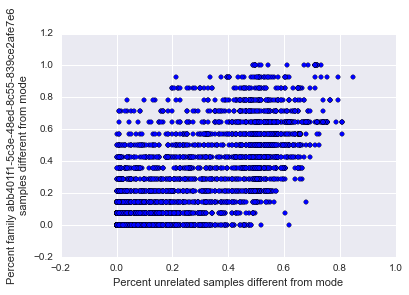

In [14]:
plt.scatter(cnv_info.unrelated_percent_diff_from_mode, cnv_info[family_cols[0]])
plt.xlabel('Percent unrelated samples different from mode')
plt.ylabel('Percent family {}\nsamples different from mode'.format(family_cols[0].split('_')[0]));

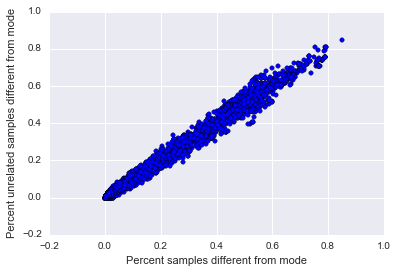

In [15]:
p1 = cnv_info.percent_diff_from_mode
p2 = cnv_info.unrelated_percent_diff_from_mode
diff = p1 - p2
diff.sort_values(inplace=True)
plt.scatter(p1, p2)
plt.xlabel('Percent samples different from mode')
plt.ylabel('Percent unrelated samples different from mode');

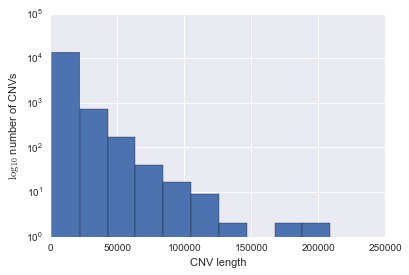

In [16]:
cnv_info.length.hist(log=True)
plt.ylabel('$\log_{10}$ number of CNVs')
plt.xlabel('CNV length');

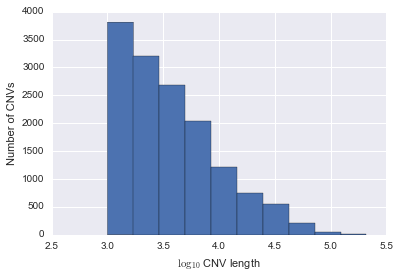

In [17]:
(np.log10(cnv_info.length)).hist()
plt.ylabel('Number of CNVs')
plt.xlabel('$\log_{10}$ CNV length');

In [18]:
cnv_info.length.describe()

count     14500.000000
mean       6615.005931
std       10552.781125
min         999.000000
25%        1660.000000
50%        3049.000000
75%        6574.250000
max      208946.000000
Name: length, dtype: float64

In [19]:
cutoffs = np.array([2, 5, 10, 50, 100, 200]) * 1000
for c in cutoffs:
    print('{:.1f}% of CNVs are less than {:,} bp'.format(
            100 * sum(cnv_info.length < c) / float(cnv_info.shape[0]), c))

32.7% of CNVs are less than 2,000 bp
67.2% of CNVs are less than 5,000 bp
84.1% of CNVs are less than 10,000 bp
99.0% of CNVs are less than 50,000 bp
99.9% of CNVs are less than 100,000 bp
100.0% of CNVs are less than 200,000 bp


### Functional annotations

I'm going to annotate the CNVs with more info.

In [24]:
def cnv_counts(url, name):
    bt = pbt.BedTool(cpb.general.read_gzipped_text_url(url), from_string=True)
    bt = bt.sort()
    res = cnv_bt.intersect(bt, sorted=True, wo=True)
    r = res[0]
    df = res.to_dataframe(names=range(len(res[0].fields)))
    vc = df[3].value_counts()
    counts = pd.DataFrame(0, columns=[name], index=cnv_info.index)
    counts.ix[vc.index, name] = vc
    return counts

def cluster_setup():
    from ipyparallel import Client
    parallel_client = Client(profile='parallel')
    dview = parallel_client[:]
    print('Cluster has {} engines.'.format(len(parallel_client.ids)))
    with dview.sync_imports():
        import cdpybio
        import pandas
        import pybedtools
    %px cpb = cdpybio
    %px pd = pandas
    %px pbt = pybedtools
    dview.push(dict(cnv_bt=cnv_bt, cnv_info=cnv_info, 
                    cnv_counts=cnv_counts))
    return dview

cluster_ready = False

#### Roadmap DNase and ChIP-seq

In [25]:
out = os.path.join(outdir, 'roadmap_overlap.tsv')
if not os.path.exists(out):
    url = ('http://egg2.wustl.edu/roadmap/data/byFileType'
           '/peaks/consolidated/narrowPeak/')
    website = urllib2.urlopen(url)
    html = website.read()
    files = re.findall('href="(.*\.gz)"', html)
    lines = [x for x in roadmap_ids.index if ('ES' in roadmap_ids[x] and 'Cultured' not in roadmap_ids[x])]
    lines += [x for x in roadmap_ids.index if 'iPS' in roadmap_ids[x]]
    files = [x for x in files if x.split('-')[0] in lines]
    files = [x for x in files if 'hotspot' not in x]

    roadmap_peak_pvals = pd.DataFrame(
        -1, index=lines, 
        columns=set([x.split('-')[1].split('.')[0] for x in files]))
    roadmap_peak_oddsratios = pd.DataFrame(
        0, index=lines, 
        columns=set([x.split('-')[1].split('.')[0] for x in files]))

    urls = ['http://egg2.wustl.edu/roadmap/data/byFileType/peaks/consolidated/narrowPeak/{}'.format(n)
            for n in files]
    lines = [roadmap_ids[re.findall('E\d{3}', url)[0]][0:-10].replace(' ', '_') for url in urls]
    btype = [re.findall('-(.+)\.', url)[0].split('.')[0] for url in urls]
    names = ['{}_{}'.format(lines[i], btype[i]) for i in range(len(lines))]
    todo = zip(urls, names)
    if cluster_ready == False:
        dview = cluster_setup()
        cluster_ready = True
    counts = dview.map_sync(lambda x: cnv_counts(x[0], x[1]), todo)
    roadmap_dnase_counts = pd.concat(counts, axis=1)
    roadmap_dnase_counts.to_csv(out, sep='\t')
else:
    roadmap_dnase_counts = pd.read_table(out, index_col=0)

#### Roadmap chromatin state

In [26]:
lines = [x for x in roadmap_ids.index if 'iPS' in roadmap_ids[x]]
for line in lines:
    fn = ('/publicdata/roadmap_25_state_20151104/'
          '{}_25_imputed12marks_mnemonics_sorted.bed'.format(line))
    bt = pbt.BedTool(fn)
    res = cnv_bt.intersect(bt, sorted=True, wo=True)
    df = res.to_dataframe(names=range(len(res[0].fields)))
    c = df.groupby([3, 7]).sum()[8]
    c = c.sort_values(ascending=False)
    t = c.unstack()
    t[t.isnull()] = 0
    name = roadmap_ids[line][:-10].replace(' ', '_')
    t.to_csv(os.path.join(outdir, '{}_chromatin_state.tsv'.format(name)), sep='\t')

#### ENCODE DNase

In [27]:
out = os.path.join(outdir, 'encode_dnase_overlap.tsv')
if not os.path.exists(out):
    encode_dnase = pd.read_table(os.path.join(ciepy.root, 'output', 
                                              'functional_annotation_analysis', 
                                              'encode_dnase.tsv'), index_col=0)
    encode_dnase = encode_dnase[encode_dnase.biosample_type == 'stem cell']
    encode_dnase['name'] = encode_dnase.cell_type + '_' + 'DNase'
    if cluster_ready == False:
        dview = cluster_setup()
        cluster_ready = True
    dview.push(dict(encode_dnase=encode_dnase));
    counts = dview.map_sync(lambda i: cnv_counts(encode_dnase.ix[i, 'narrowPeak_url'], 
                                                 encode_dnase.ix[i, 'name']), 
                            encode_dnase.index)
    encode_dnase_counts = pd.concat(counts, axis=1)
    encode_dnase_counts.to_csv(out, sep='\t')
else:
    encode_dnase_counts = pd.read_table(out, index_col=0)

#### ENCODE ChIP-seq

In [28]:
out = os.path.join(outdir, 'encode_tf_chip_seq_overlap.tsv')
if not os.path.exists(out):
    encode_tf_chip_seq = pd.read_table(os.path.join(ciepy.root, 'output', 
                                                    'functional_annotation_analysis', 
                                                    'encode_stem_cell_chip_seq.tsv'), index_col=0)
    encode_tf_chip_seq = encode_tf_chip_seq.drop_duplicates(subset='target')
    encode_tf_chip_seq['name'] = encode_tf_chip_seq.cell_type + '-' + encode_tf_chip_seq.target
    if cluster_ready == False:
        dview = cluster_setup()
        cluster_ready = True
    dview.push(dict(encode_tf_chip_seq=encode_tf_chip_seq));
    counts = dview.map_sync(lambda i: cnv_counts(encode_tf_chip_seq.ix[i, 'narrowPeak_url'], 
                                                 encode_tf_chip_seq.ix[i, 'name']), 
                            encode_tf_chip_seq.index)
    encode_tf_chip_seq_counts = pd.concat(counts, axis=1)
    encode_tf_chip_seq_counts.to_csv(out, sep='\t')
else:
    encode_tf_chip_seq_counts = pd.read_table(out, index_col=0)

## EMMAX CNVs

I want to find CNVs that I can include in the EMMAX association analysis. 

### GenomeStrip

For GS, I can use CNVs that have at most three copy number states and have a
minor allele frequency greater than 1% (aka at least 1% of samples differ from 
the mode copy number state). I can also separately test mCNVs for an association 
with gene expression.

In [165]:
# Get copy number states for samples in eQTL analysis.
cns_f = cns[rna_meta[rna_meta.in_eqtl].wgs_id]
# Get the number of distinct copy number states for each CNV.
num_states = cns_f.apply(lambda x: len(set(x)), axis=1)
# Keep CNVs with two or three states.
cns_emmax = cns_f.ix[num_states[num_states.apply(lambda x: x in [2, 3])].index]
# Remove CNVs where less than 1% of the samples are different from the mode.
b = (cns_emmax.apply(lambda x: x.value_counts().max() < 
                     cns_emmax.shape[1] - np.floor(rna_meta.in_eqtl.sum() * 0.01), axis=1))
cns_emmax = cns_emmax[b]

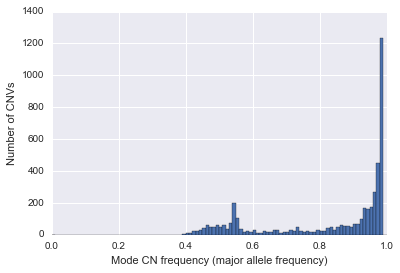

In [166]:
maj_af = cns_emmax.apply(lambda x: x.value_counts().max(), axis=1) / cns_emmax.shape[1]
maj_af.hist(bins=np.arange(0, 1.01, 0.01))
plt.ylabel('Number of CNVs')
plt.xlabel('Mode CN frequency (major allele frequency)');

In [167]:
t = cnv_info.ix[cns_emmax.index]
s = '\n'.join(t.chrom + '\t' + t.start.astype(str) + '\t' + t.end.astype(str) + 
              '\t' + t.name) + '\n'
cns_emmax_bt = pbt.BedTool(s, from_string=True)
cns_emmax_bt = cns_emmax_bt.sort()

fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'variant_regions.bed')
variant_regions = pbt.BedTool(fn)
genes_todo = set(exp.index)

res = cns_emmax_bt.intersect(variant_regions, sorted=True, wo=True)
g = []
for r in res:
    g.append(r.fields[-3].split('_')[0])
cnv_gene_vc = pd.Series(g).value_counts()
cnv_gene_vc = cnv_gene_vc[set(cnv_gene_vc.index) & genes_todo]

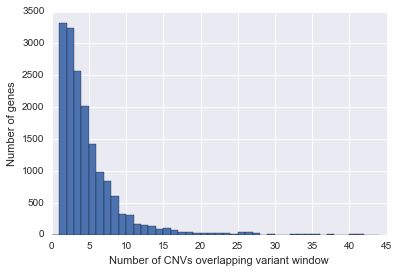

In [168]:
cnv_gene_vc.hist(bins=range(cnv_gene_vc.max()))
plt.ylabel('Number of genes')
plt.xlabel('Number of CNVs overlapping variant window');

I think that I can collapse some mCNVs to be biallelic. For instance, the CNV
below has one person with copy number 4, but if we exclude that person, we would
only have three copy number states. The person who is four is likely just an error and
should actually be 3, or at the least it wouldn't hurt to make them copy number 3 or 
just not include them in the analysis.

In [169]:
report.ix['CNV_19_40372246_40375846']

CALLRATE               0.989
CNMIN                      1
CNMAX                      4
CNALLELES                  3
NNONREF                  140
NVARIANT                 140
CNCATEGORY             MIXED
CNDIST        0,109,131,30,1
Name: CNV_19_40372246_40375846, dtype: object

In [170]:
t = cns_f.ix[set(cns_f.index) - set(cns_emmax.index)]
t = t[t.apply(lambda x: len(set(x)) > 3, axis=1)]
# b has the number of samples that have one of the top three copy number states
b = t.apply(lambda x: x.value_counts()[0:3].sum(), axis=1)

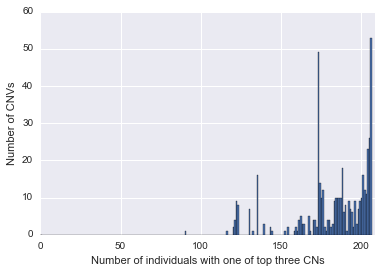

In [171]:
b.hist(bins=range(208))
plt.xlim(0, 209)
plt.ylabel('Number of CNVs')
plt.xlabel('Number of individuals with one of top three CNs');

This plot shows us that many CNVs are almost biallelic. If we remove 
a few samples, we can make more sites biallelic.

In [172]:
sum(b >= rna_meta.in_eqtl.sum() * 0.95)

807

There are 807 CNVs for which I can remove people with rare copy numbers
and still have 95% call rate. I'll set the rare copy numbers to missing
and include these.

In [173]:
rows = []
for i in b[b >= rna_meta.in_eqtl.sum() * 0.95].index:
    se = cns_f.ix[i]
    vc = se.value_counts()
    se[se.apply(lambda x: x not in vc.index[0:3])] = np.nan
    rows.append(se)
df = pd.DataFrame(rows, index=b[b >= rna_meta.in_eqtl.sum() * 0.95].index, 
                  columns=cns_f.columns)

In [174]:
b = df.apply(lambda x: x.value_counts().max() < df.shape[1] - np.floor(rna_meta.in_eqtl.sum() * 0.05), axis=1)
df = df[b]

In [175]:
cns_emmax = pd.concat([cns_emmax, df])
cns_emmax.to_csv(os.path.join(private_outdir, 'gs_emmax_cnvs.tsv'), sep='\t')

In [176]:
cns_emmax.shape

(5348, 215)

I want to remove CNV in the MHC region because these are likely alignment artifacts.
[`Bioinformatics and Functional Genomics` by Jonathan Pevsner](https://books.google.com/books?id=FKRjCgAAQBAJ&pg=PA50&lpg=PA50&dq=ucsc+genome+browser+mhc&source=bl&ots=6i7JYq_oA5&sig=DlZM3EvEmc5G4hLSK-0haSDz7vM&hl=en&sa=X&ved=0ahUKEwid0auysI_LAhXKLyYKHZkqD1YQ6AEIRjAH#v=onepage&q=ucsc%20genome%20browser%20mhc&f=false) 
says the MHC is ~29.6 to 33.1 mb on chromosome 6 so I'll use that.

In [177]:
t = cnv_info.ix[cns_emmax.index]
s = '\n'.join(t.chrom + '\t' + t.start.astype(str) + '\t' + t.end.astype(str) + 
              '\t' + t.name) + '\n'
cns_emmax_bt = pbt.BedTool(s, from_string=True)
cns_emmax_bt = cns_emmax_bt.sort()
mhc_bt = pbt.BedTool('chr6\t{}\t{}'.format(int(29.6e6), int(33.1e6)), from_string=True)
res = cns_emmax_bt.intersect(mhc_bt, wa=True, v=True)
df = res.to_dataframe()
cns_emmax = cns_emmax.ix[df.name]

In [178]:
cns_emmax.shape

(5287, 215)

I'll write a VCF file with the CNV genotypes.

In [179]:
cns_emmax_genotypes = cns_emmax.copy(deep=True).astype(str)
mins = cns_emmax.apply(lambda x: x == x.min(), axis=1)
maxs = cns_emmax.apply(lambda x: x == x.max(), axis=1)
nulls = cns_emmax.isnull()
hets = (mins.astype(int) + maxs.astype(int) + nulls.astype(int) == 0)
cns_emmax_genotypes[mins] = '0/0'
cns_emmax_genotypes[hets] = '0/1'
cns_emmax_genotypes[maxs] = '1/1'
cns_emmax_genotypes[nulls] = './.'

In [180]:
cns_emmax_info = cnv_info.ix[cns_emmax.index, ['chrom', 'start']]
cns_emmax_info.chrom = cns_emmax_info.chrom.apply(lambda x: x[3:])
#cns_emmax_info = cns_emmax_info.drop(['end', 'length'], axis=1)
cns_emmax_info.start = cns_emmax_info.start.astype(str)
cns_emmax_info['id'] = cns_emmax_info.index
cns_emmax_info['ref'] = 'N'
cns_emmax_info['alt'] = 'N'
cns_emmax_info['qual'] = '100000'
cns_emmax_info['filter'] = 'PASS'
cns_emmax_info['info'] = ''
cns_emmax_info['format'] = 'GT'
cns_emmax_info = cns_emmax_info.join(cns_emmax_genotypes[sorted(cns_emmax_genotypes.columns)])

In [181]:
with open('/projects/CARDIPS/analysis/cardips-ipsc-eqtl/misc/header.vcf') as f:
    lines = f.readlines()
vs = lines[-1].strip().split('\t')[9:]
colnames = lines[-1].strip().split('\t')[0:9]

In [182]:
out = os.path.join(private_outdir, 'gs_emmax_sorted.vcf')
if not os.path.exists(out):
    with open(os.path.join(private_outdir, 'gs_emmax.vcf'), 'w') as f:
        f.write(''.join(lines[0:-1]))
        f.write('\t'.join(colnames + list(cns_emmax_info.columns[9:])) + '\n')
        f.write('\n'.join(cns_emmax_info.apply(lambda x: '\t'.join(x), axis=1)) + '\n')
    !cat {os.path.join(private_outdir, 'gs_emmax.vcf')} | vcf-sort > {out}
    !bgzip {out}
    !bcftools index {out}.gz
    !bcftools index -t {out}.gz
    !rm {os.path.join(private_outdir, 'gs_emmax.vcf')}

sort -k1,1d -k2,2n


Let's see which genes have CNVs to test now that we've added in some more CNVs.

In [183]:
t = cnv_info.ix[cns_emmax.index]
s = '\n'.join(t.chrom + '\t' + t.start.astype(str) + '\t' + t.end.astype(str) + 
              '\t' + t.name) + '\n'
cns_emmax_bt = pbt.BedTool(s, from_string=True)
cns_emmax_bt = cns_emmax_bt.sort()

res = cns_emmax_bt.intersect(variant_regions, sorted=True, wo=True)
g = []
for r in res:
    g.append(r.fields[-3].split('_')[0])
cnv_gene_vc = pd.Series(g).value_counts()
cnv_gene_vc = cnv_gene_vc[set(cnv_gene_vc.index) & genes_todo]

In [184]:
t = cnv_info.ix[cns_emmax.index]
s = '\n'.join(t.chrom + '\t' + t.start.astype(str) + '\t' + t.end.astype(str) + 
              '\t' + t.name) + '\n'
cns_emmax_bt = pbt.BedTool(s, from_string=True)
cns_emmax_bt = cns_emmax_bt.sort()

In [185]:
cnv_gene_vc.shape

(16854,)

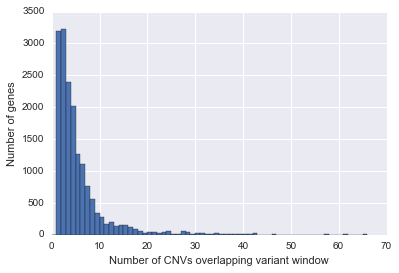

In [186]:
cnv_gene_vc.hist(bins=range(cnv_gene_vc.max()))
plt.ylabel('Number of genes')
plt.xlabel('Number of CNVs overlapping variant window');

### Lumpy

In [268]:
lumpy_genotypes_f = lumpy_genotypes[rna_meta_eqtl.wgs_id]

In [269]:
lumpy_ref_ac = lumpy_genotypes_f.apply(lambda x: ''.join(x).count('0'), axis=1)
lumpy_alt_ac = lumpy_genotypes_f.apply(lambda x: ''.join(x).count('1'), axis=1)

lumpy_ref_af = lumpy_ref_ac.astype(float) / (lumpy_ref_ac + lumpy_alt_ac)
lumpy_alt_af = lumpy_alt_ac.astype(float) / (lumpy_ref_ac + lumpy_alt_ac)

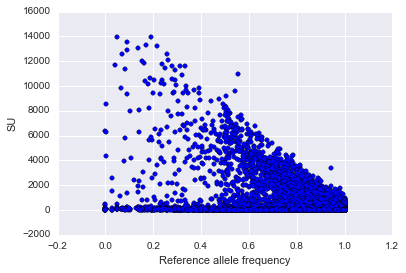

In [270]:
plt.scatter(lumpy_ref_af, lumpy_info.SU)
plt.ylabel('SU')
plt.xlabel('Reference allele frequency');

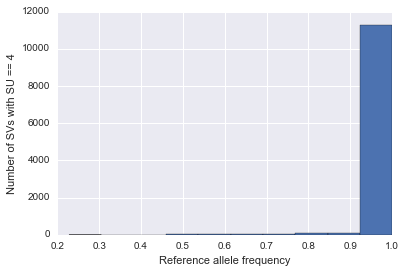

In [271]:
lumpy_ref_af[lumpy_info[lumpy_info.SU == 4].index].hist()
plt.xlabel('Reference allele frequency')
plt.ylabel('Number of SVs with SU == 4');

In [272]:
lumpy_af = pd.DataFrame({'ref':lumpy_ref_af, 'alt':lumpy_alt_af})
lumpy_af['maj_af'] = lumpy_af.max(axis=1)
lumpy_af['min_af'] = lumpy_af.min(axis=1)

In [273]:
n = lumpy_af[lumpy_af.min_af >= 0.01].shape[0]
print('{:,} lumpy SVs have minor allele frequency > 1%.'.format(n))

11,301 lumpy SVs have minor allele frequency > 1%.


I'll make a VCF file like I did for GS. I'll make them similarly formatted.

In [274]:
lumpy_keep = lumpy_af[lumpy_af.min_af >= 0.01].index

In [275]:
t = lumpy_info.ix[lumpy_keep]
s = '\n'.join(t.CHROM + '\t' + t.POS.astype(str) + '\t' + t.END.astype(str) + 
              '\t' + t.name) + '\n'
lumpy_emmax_bt = pbt.BedTool(s, from_string=True)
lumpy_emmax_bt = lumpy_emmax_bt.sort()
mhc_bt = pbt.BedTool('chr6\t{}\t{}'.format(int(29.6e6), int(33.1e6)), from_string=True)
res = lumpy_emmax_bt.intersect(mhc_bt, wa=True, v=True)
df = res.to_dataframe()
lumpy_keep = list(df.name)

In [278]:
lumpy_emmax_info = lumpy_info.ix[lumpy_keep, ['CHROM', 'POS','ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'END']]
lumpy_emmax_info.CHROM = lumpy_emmax_info.CHROM.apply(lambda x: x[3:])
lumpy_emmax_info.ID = (lumpy_emmax_info.ALT + '_' + lumpy_emmax_info.CHROM + 
                       '_' + lumpy_emmax_info.POS.astype(str) + '_' + lumpy_emmax_info.END.astype(str))
lumpy_emmax_info.ALT = 'N'
lumpy_emmax_info.FILTER = 'PASS'
lumpy_emmax_info = lumpy_emmax_info.drop('END', axis=1)
lumpy_emmax_info['INFO'] = ''
lumpy_emmax_info['FORMAT'] = 'GT'
lumpy_emmax_info = lumpy_emmax_info.join(lumpy_genotypes_f[sorted(lumpy_genotypes_f.columns)])
lumpy_emmax_info = lumpy_emmax_info.astype(str)

In [281]:
with open('/projects/CARDIPS/analysis/cardips-ipsc-eqtl/misc/header.vcf') as f:
    lines = f.readlines()
vs = lines[-1].strip().split('\t')[9:]
colnames = lines[-1].strip().split('\t')[0:9]

In [282]:
out = os.path.join(private_outdir, 'lumpy_emmax_sorted.vcf')
if not os.path.exists(out):
    with open(os.path.join(private_outdir, 'lumpy_emmax.vcf'), 'w') as f:
        f.write(''.join(lines[0:-1]))
        f.write('\t'.join(colnames + list(lumpy_emmax_info.columns[9:])) + '\n')
        f.write('\n'.join(lumpy_emmax_info.apply(lambda x: '\t'.join(x), axis=1)) + '\n')
    !cat {os.path.join(private_outdir, 'lumpy_emmax.vcf')} | vcf-sort > {out}
    !bgzip {out}
    !bcftools index {out}.gz
    !bcftools index -t {out}.gz
    !rm {os.path.join(private_outdir, 'lumpy_emmax.vcf')}

sort -k1,1d -k2,2n


## mCNVs

I want to identify mCNVs that I can test for associations with gene expression. 
I'll filter the mCNVs more in the notebook where I do the analysis.

In [78]:
mcnvs = cns_f.ix[num_states[num_states > 3].index]
mcnvs_f = mcnvs.ix[set(mcnvs.index) - set(cns_emmax.index)]
mcnvs_f.to_csv(os.path.join(private_outdir, 'mcnvs.tsv'), sep='\t')